In [ ]:
!pip install sentence_transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
import os
import shutil
import pickle
import re
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
from transformers import pipeline
warnings.filterwarnings('ignore')

# Step 1 - Load the data

In [9]:
full_df = pd.read_csv("/content/drive/MyDrive/metadata.csv")
dfs = []
for year in range(2019, 2020):
    df = pd.read_csv(f"/content/drive/MyDrive/310Project/deduplicated_dataset_{year}.csv", index_col=0)
    df.drop(columns=["minhash"], inplace=True)
    dfs.append(df)
df = pd.concat(dfs)
# Left join on the "cord_uid" column
df = pd.merge(df, full_df[['cord_uid', 'abstract']], on="cord_uid", how="left")
df.dropna(subset=['abstract'], inplace=True) #drop articles with null abstracts
df.to_pickle("prepared_data.pkl")

In [10]:
df = pd.read_pickle("prepared_data.pkl")

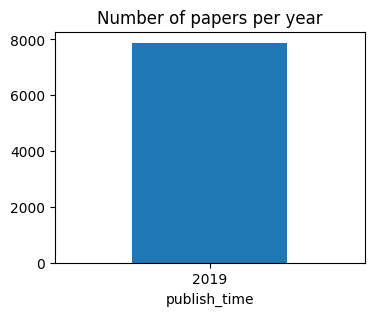

In [11]:
# Plot the number of papers per year
df.groupby("publish_time").count()["cord_uid"].plot(kind="bar",
    title="Number of papers per year", figsize=(4, 3))
plt.xticks(rotation=0)
plt.show()

# Step 1 - Get sentence embeddings

In [12]:
DEVICE = "cuda"
SENTENCE_ENCODER = SentenceTransformer('all-mpnet-base-v2', device=DEVICE)
embeddings = SENTENCE_ENCODER.encode(df.abstract.tolist(), show_progress_bar=True)

Batches:   0%|          | 0/247 [00:00<?, ?it/s]

In [ ]:
#embeddings = np.load("data/embeddings.npy")

In [13]:
# Concat embeddings to dataframe
df['Embeddings'] = list(embeddings)


In [ ]:
#df.to_csv('/content/drive/MyDrive/310Project/embeddings.csv')

# Step 2 - Topic Modeling for 2019

In [ ]:
import warnings
import os
import shutil
import pickle
import re
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
from transformers import pipeline
warnings.filterwarnings('ignore')

In [ ]:
#df = pd.read_csv("/content/drive/MyDrive/310Project/embeddings.csv")

In [14]:
year = 2019

df_year = df[df.publish_time == year]
print(f"Processing year {year} with {len(df_year)} samples...")

Processing year 2019 with 7883 samples...


In [15]:
# Concat embeddings to dataframe
embedding_df = np.stack(df_year.Embeddings.tolist())
print(embedding_df.shape)

(7883, 768)


In [16]:
# Perform PCA
pca = PCA(n_components=0.90)
embedding_pca = pca.fit_transform(embedding_df)
print(f"Reduced {embedding_df.shape[1]} to {embedding_pca.shape[1]} dimensions.")

Reduced 768 to 197 dimensions.


In [ ]:
# KMeans
kmeans_data = dict()

for k in tqdm(range(5, 20)):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embedding_pca)
    kmeans_data[k] = dict(
        labels=kmeans.labels_,
        inertia=kmeans.inertia_,
    )

100%|██████████| 15/15 [01:10<00:00,  4.71s/it]


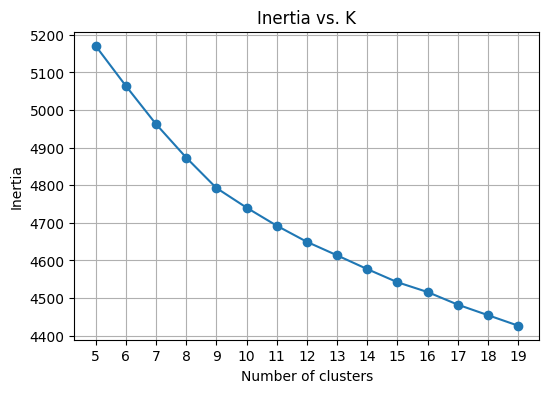

In [ ]:
# Plot the inertia vs. K
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(list(kmeans_data.keys()), [km['inertia'] for km in kmeans_data.values()], marker='o')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
ax.set_title('Inertia vs. K')
ax.set_xticks(list(kmeans_data.keys()))
ax.grid(True)
plt.show()

In [ ]:
# Choose K = 9
k = 9

In [ ]:
# Save the labels
topic_idx = kmeans_data[k]['labels']
df_year['topics9_idx'] = topic_idx
df_year.to_pickle('/content/drive/MyDrive/310Project/2019_df_year.pkl')#changed name to 2019_df_year

In [ ]:
# Perform T-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding_df)

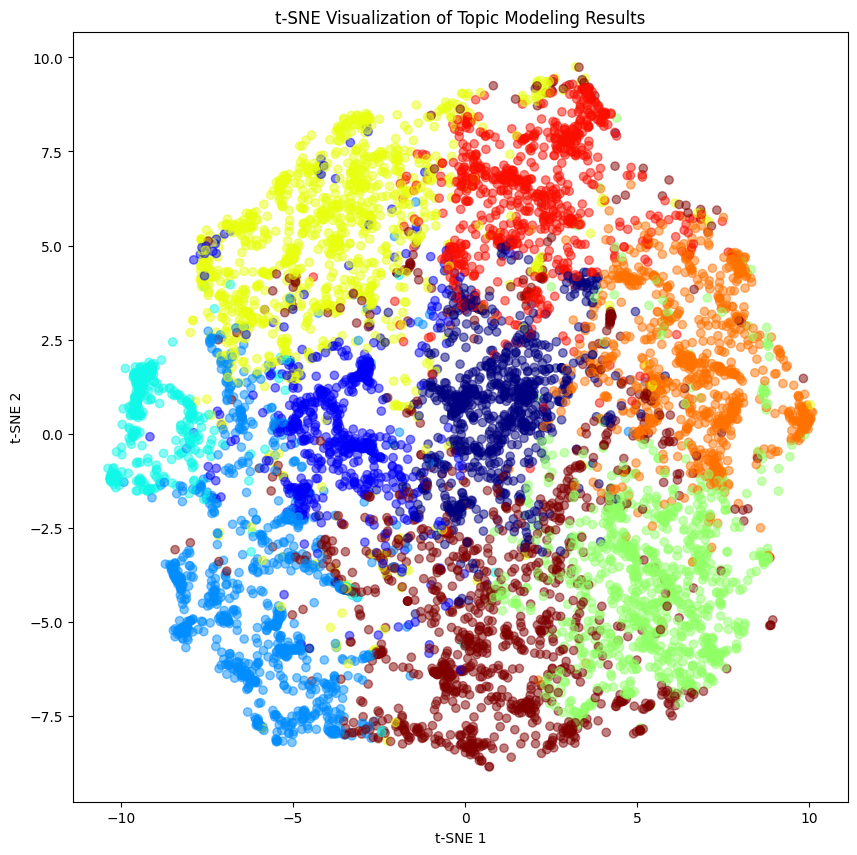

In [ ]:
# Plot the T-SNE results
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=df_year.topics9_idx,
            cmap=plt.cm.get_cmap("jet", 20), alpha=0.5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization of Topic Modeling Results")
plt.show()

In [17]:
#minibatch
from sklearn.cluster import MiniBatchKMeans

In [18]:
kmeans_data = {}
for k in tqdm(range(10, 500, 5)):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=1000, max_iter=100)
    kmeans.fit(embedding_pca)
    kmeans_data[k] = dict(
        labels=kmeans.labels_,
        inertia=kmeans.inertia_,
    )

100%|██████████| 98/98 [05:03<00:00,  3.10s/it]


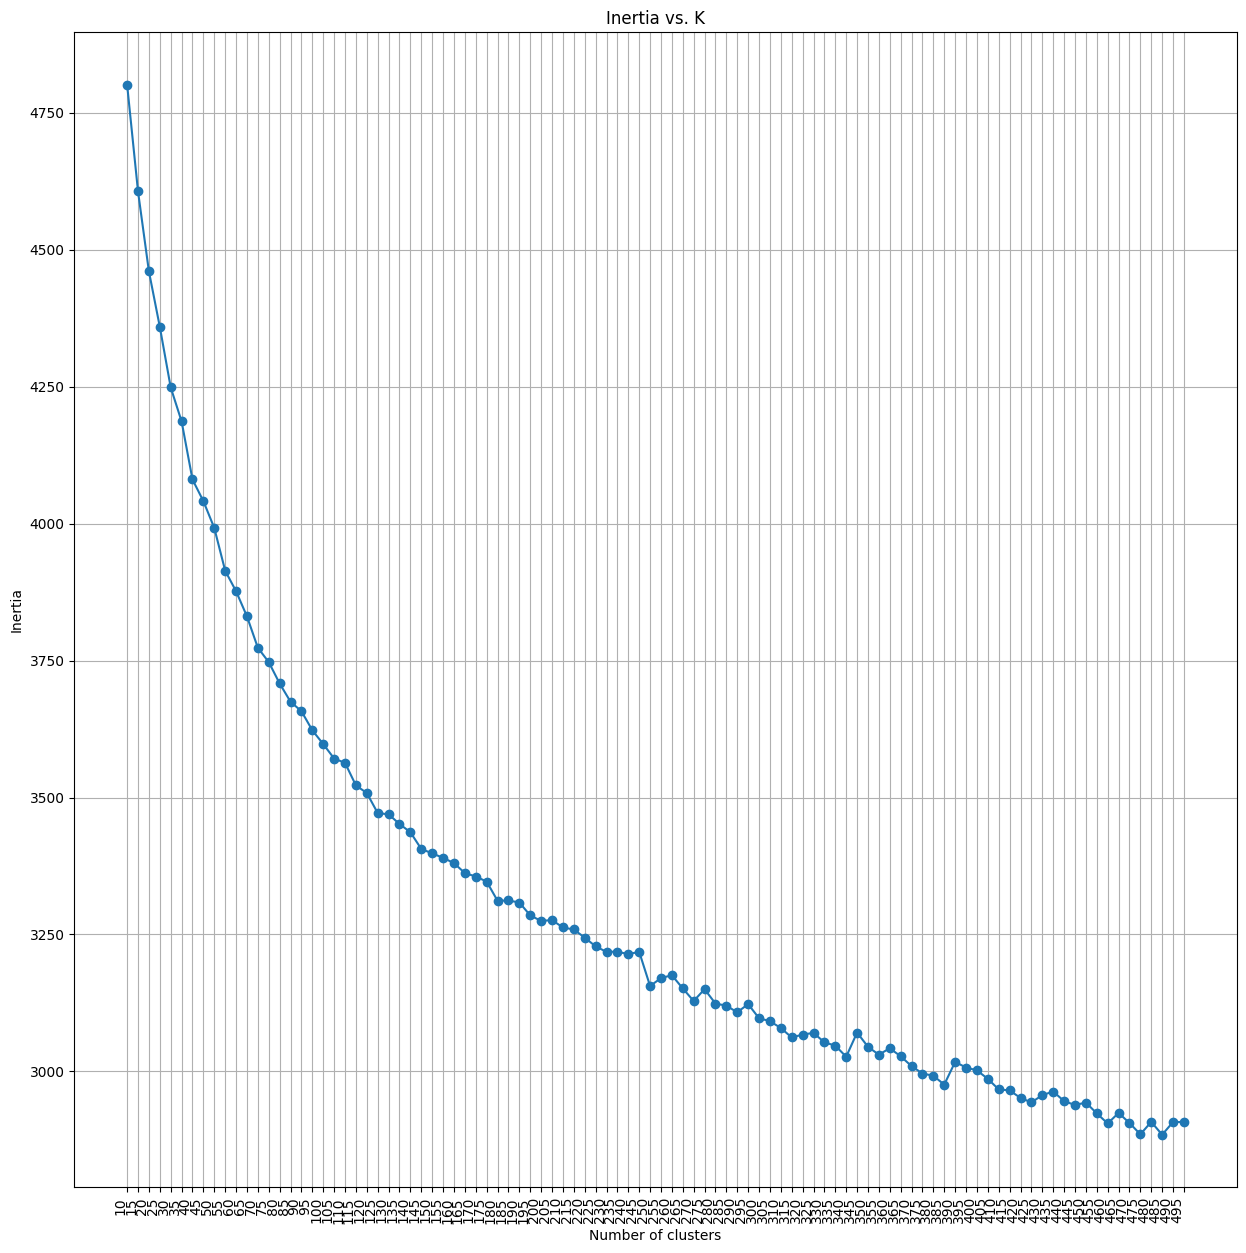

In [19]:
# plot the inertia vs. K
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(list(kmeans_data.keys()), [km['inertia'] for km in kmeans_data.values()], marker='o')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
ax.set_title('Inertia vs. K')
ax.set_xticks(list(kmeans_data.keys()))
ax.grid(True)
plt.xticks(rotation=90, ha='right')
plt.show()

In [29]:
k = 215

In [31]:
# save the labels
topic_idx = kmeans_data[k]['labels']
df_year['topics215_idx'] = topic_idx
df_year.to_pickle('/content/drive/MyDrive/310Project/2019_df_year.pkl')

In [32]:
# Perform T-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding_pca)


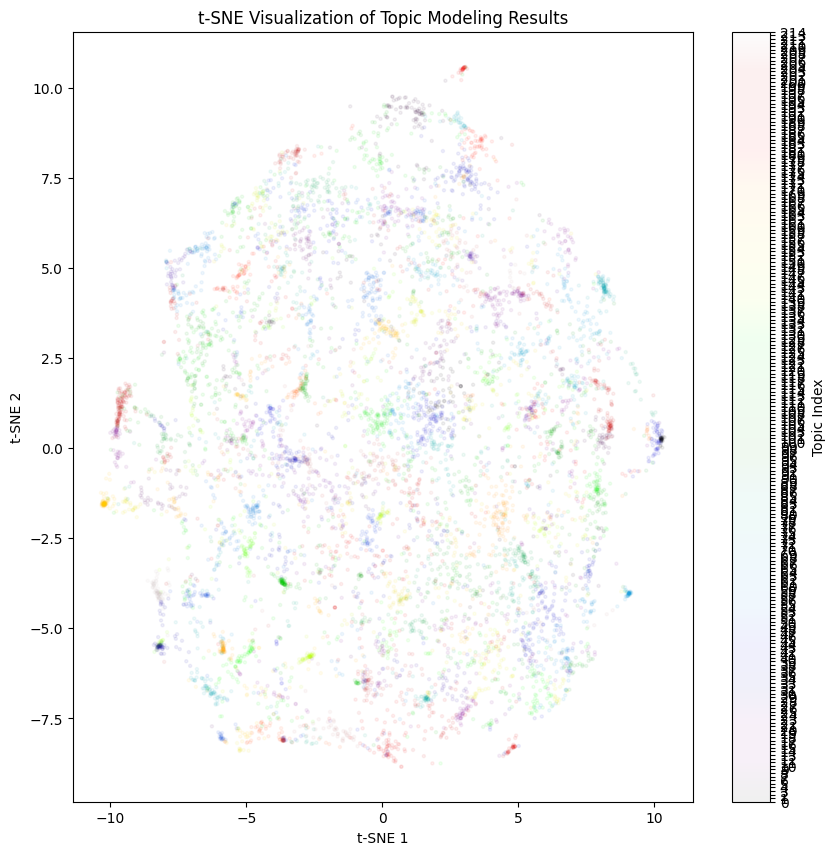

In [33]:
# Plot the T-SNE results
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(tsne_results[:,0], tsne_results[:,1], c=df_year.topics215_idx,
                     cmap=plt.cm.nipy_spectral, alpha=0.06, s=5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization of Topic Modeling Results")
# Add a colorbar for reference
cbar = plt.colorbar(scatter, ticks=range(215))
cbar.set_label('Topic Index')
plt.show()


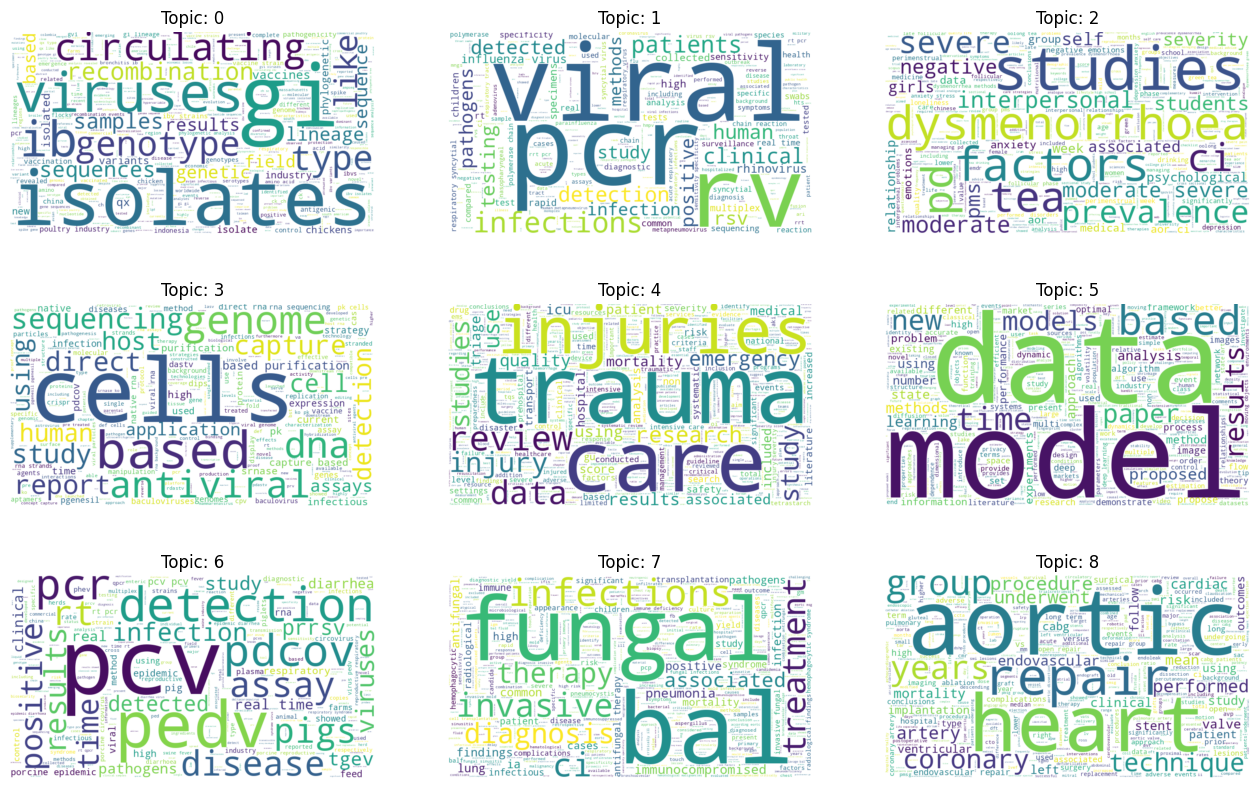

In [35]:
# Generate word cloud for each topic
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
axes = axes.flatten()
pattern = re.compile("[^a-zA-Z]")

keywords = []

for i in range(9):
    df_topic = df_year[df_year.topics215_idx == i]

    corpus = df_topic.abstract.values
    # Remove non-alphabetical characters
    corpus = [re.sub(pattern, " ", text) for text in corpus]

    # Use TF-IDF to extract frequencies since it is more flexible
    # Remove words that appear in more than 50% of the documents
    # Also include bigrams
    vectorizer = CountVectorizer(max_df=0.5, stop_words="english",
                                 lowercase=True, ngram_range=(1, 2), max_features=1000)
    vectorizer.fit(corpus)

    # Get the word frequencies dict(string:float)
    tokens = vectorizer.get_feature_names_out()
    freqs = vectorizer.transform(corpus).sum(axis=0).A1
    freqs = freqs / freqs.max()
    tokens_to_freqs = dict(zip(tokens, freqs))
    # Sort the dict by values
    tokens_to_freqs = dict(sorted(tokens_to_freqs.items(), key=lambda x: x[1], reverse=True))
    # Get the top 10 keywords
    keywords.append(list(tokens_to_freqs.keys())[:10])

    # Word cloud
    wordcloud = WordCloud(width=900, height=500,
                          background_color="white", max_words=1628,
                          relative_scaling=1, normalize_plurals=False).generate_from_frequencies(tokens_to_freqs)
    wordcloud.to_file("/content/drive/MyDrive/310Project/2019_topic_" + str(i) + ".png")
    ax = axes[i]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title("Topic: " + str(i))

plt.show()

In [36]:
# Save the keywords to file
with open("/content/drive/MyDrive/310Project/2019_keywords.json", 'w') as f:
    json.dump(keywords, f)

# Text Summarization

#### restart the kernal is strongly recommended before run the following code

In [37]:
# Load the dataframe
BART_SUMMARIZER = pipeline("summarization", model="facebook/bart-large-cnn", device="cuda")

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [38]:
# Load the dataframe
df_2019 = pd.read_pickle("/content/drive/MyDrive/310Project/2019_df_year.pkl")
df_2019.columns

Index(['cord_uid', 'title', 'publish_time', 'language', 'abstract',
       'Embeddings', 'topics215_idx', 'topics255_idx'],
      dtype='object')

In [39]:
# Get the representative articles for each topic

topic_repr_articles = {}

for topic_idx in tqdm(df_2019.topics215_idx.unique()):
    # Get the embeddings for the topic
    df_topic = df_2019[df_2019.topics215_idx == topic_idx]
    # if length of topic < 20, skip
    if len(df_topic) < 20:
        continue
    topic_embeddings = np.stack(df_topic.Embeddings.values)

    # Perform PCA
    pca = PCA(n_components=0.9)
    emb_pca = pca.fit_transform(topic_embeddings)

    # Perform KMeans
    n_repr_articles = 5
    km = KMeans(n_clusters=n_repr_articles, random_state=0)
    km.fit(emb_pca)
    labels = km.labels_
    centroids = km.cluster_centers_

    # Get the representative articles based on the centroids
    repr_articles = []
    for label, centroid in zip(range(n_repr_articles), centroids):
        distances = np.linalg.norm(emb_pca - centroid, axis=1)
        repr_articles.append(df_topic.iloc[np.argmin(distances)].abstract)
    # Save the representative articles
    topic_repr_articles[topic_idx] = repr_articles

100%|██████████| 215/215 [00:13<00:00, 16.20it/s]


In [40]:
# Save topic_repr_articles
topic_repr_articles = {int(key): value for key, value in topic_repr_articles.items()}
with open("/content/drive/MyDrive/310Project/topic_repr_articles.json", 'w') as f:
    json.dump(topic_repr_articles, f)

In [41]:
topic_idx = 88
#print (topic_repr_articles[topic_idx]) in a more readable way with rank

# print (topic_repr_articles[topic_idx])
# print ("")

# for i in range(0, len(topic_repr_articles[topic_idx])+1):
#     print (topic_repr_articles[topic_idx][i])
#     print ("")

for i in range(0, len(topic_repr_articles[topic_idx])):
    print(topic_repr_articles[topic_idx][i])
    print("")

OBJECTIVES CR2 is the main receptor for complement protein C3 and plays an important role in adaptive immune responses. CR2 genetic variants are associated with susceptibility to systemic lupus erythematosus as well as to HIV-1 infection. Additionally, CR2 function can be subverted by HIV-1 for an efficient entry into target cells; in a process known as antibody-dependent enhancement of viral infection. We sought to determine the association between CR2 gene variants with HIV-1 acquisition after vaccination with recombinant gp120 protein (Vax004 clinical trial). DESIGN AND METHODS This is a retrospective cross-sectional study, comprising male subjects of European ancestry including infected (n = 273) and uninfected (n = 402) vaccinees and placebo, who were genotyped for 3 SNPs in the CR2 gene region. RESULTS An interaction was observed between the baseline sexual behaviour and the SNP rs3813946 for higher risk of infection in vacinees (interaction term p = 0.02). This SNP was associate

In [42]:
# Load topic_repr_articles and convert keys to int
with open("/content/drive/MyDrive/310Project/topic_repr_articles.json", 'r') as f:
    topic_repr_articles = json.load(f)
topic_repr_articles = { int(k): v for k, v in topic_repr_articles.items() }

In [43]:
import os
import json

file_path = "/content/drive/MyDrive/310Project/summaries.json"

# Check if the file exists
if not os.path.isfile(file_path):
    print(f"File not found: {file_path}")
    # Handle the case where the file doesn't exist by creating an empty dict
    topic_summaries = {}
else:
    # If the file exists, proceed to load it
    with open(file_path, 'r') as f:
        topic_summaries = json.load(f)
    topic_summaries = {int(k): v for k, v in topic_summaries.items()}

In [ ]:
# # Load the summaries
# with open("/content/drive/MyDrive/310Project/summaries.json", 'r') as f:
#     topic_summaries = json.load(f)
# topic_summaries = { int(k): v for k, v in topic_summaries.items() }

In [44]:
# Summarize the articles
for topic_idx in tqdm(df_2019.topics215_idx.unique()):
    topic_idx = int(topic_idx)

    # If topic already done, skip
    if topic_idx in topic_summaries or topic_idx not in topic_repr_articles:
        continue

    # Get the representative articles
    repr_articles = topic_repr_articles[topic_idx]
    # Summarize the articles
    summaries = []
    for article in repr_articles:

        # If number of tokens > 1023, discard the texts after that
        # Since the maximum allowed length to BART summarizer is 1024
        tokens = BART_SUMMARIZER.tokenizer.tokenize(article)
        ids = BART_SUMMARIZER.tokenizer.convert_tokens_to_ids(tokens)

        while len(ids) > 1023:
            # If too long, cut half of an article
            article = article[:(len(article) // 2)]
            tokens = BART_SUMMARIZER.tokenizer.tokenize(article)
            ids = BART_SUMMARIZER.tokenizer.convert_tokens_to_ids(tokens)

        # If length is already too short, we use itself as summary
        if len(tokens) < 50:
            sumamry = article
        else:
            summary = BART_SUMMARIZER(article, max_length=50, min_length=10, do_sample=False)[0]['summary_text']

        summaries.append(summary)
    # Save the summaries
    topic_summaries[topic_idx] = summaries

    with open("/content/drive/MyDrive/310Project/summaries.json", 'w') as f:
        json.dump(topic_summaries, f)

100%|██████████| 215/215 [00:00<00:00, 712865.90it/s]


In [45]:
# Print the summaries
topic_idx = 88
# for i in range(5):
#     print (topic_summaries[topic_idx][i])
#     print ("")

for i in range(0, len(topic_summaries[topic_idx])):
    print (topic_summaries[topic_idx][i])
    print ("")

This paper voices the opinions of international students’ from China and India. Data on those perceptions were analysed using a probabilistic model. The findings enabled us to draw comparisons between two major sending countries.

There are multiple factors that can potentially impact the career progression of academics to professoriate level (referred to as levels D and E in Australia) This research provides a detailed understanding of critical factors (by gender) that negatively influence career progress

The study was anonymous and encompassed a sample of 140 students. The surveys were conducted in the third quarter of 2020, after the SARS-CoV-2 pandemic outbreak. The respondents would like their future, post-p

The purpose of this research was to explore the relationship between university students’ perceptions of the overall quality of instruction (PQI) and their academic well-being. This relationship was examined in the context of a moderated moderation with

The purpose of this 